In [1]:
# getting the library that has some of the functions needed for simulations
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time
from numba import njit, prange
import pandas as pd

%matplotlib inline

#### Functions
The below functions are same as earlier and help in setting up the calculations for the simulations

_The details of the functions have been explored while generating other figures_

In [2]:
@jit(nopython=True)
def cdf_inv_fr(u, gamma):
  return ((pow(-np.log(u) , -gamma)))

@jit(nopython=True)
def cdf_inv_H(u , gamma, beta):
  return (pow(-np.log(u)/(pow(beta , -1/gamma)-1) , -gamma) )

@jit(nopython=True)
def armax(beta , gamma, n):
  x = np.zeros(n)
  u = np.random.uniform(0,1,1)[0]
  x0 = cdf_inv_fr(u,gamma)
  xi_lag = x0
  x[0] = x0
  t = 1
  for i in range(n-1):
    u = np.random.uniform(0,1,1)[0]
    zi = cdf_inv_H(u,gamma,beta)
    xi = beta*max(xi_lag , zi)
    xi_lag = xi
    x[t] = xi
    t = t + 1
  return x

In [3]:
@jit(nopython=True)
def theta_n_k(X, n, k_=1):
  sum = 0
  k = int(k_)

  X_k = np.partition(X, n-k-1)[n-k-1]
  #if k <= 1:
  # return 1

  #X_k = max(X[n-k:n])
  
  for j in range(n-1):
    # k-th top order equals n-k low order
    if X[j] <= X_k and X[j+1] > X_k:
      sum += 1

  if k == 0:
    return 1

  #if sum/k >= 1:
  #  return 1
  return sum/k


@jit(nopython=True)
def theta_GJ_k(X, n, k, delta):
  #n = X.shape[0]

  numerator = (delta*delta + 1) * theta_n_k(X,n, int(np.floor(delta*k)) + 1) - delta*(theta_n_k(X, n, int(np.floor(delta*delta*k)) + 1) + theta_n_k(X, n, k))
  denominator = (1 - delta)**2

  if numerator < 0: 
    return 0

  #return (numerator/denominator if numerator/denominator <= 1 else 1)
  return numerator/denominator

In [4]:
@jit(nopython = True)
def np_apply_along_axis(func1d, axis, arr):
  assert arr.ndim == 2
  assert axis in [0, 1]
  if axis == 0:
    result = np.empty(arr.shape[1])
    for i in range(len(result)):
      result[i] = func1d(arr[:, i])
  else:
    result = np.empty(arr.shape[0])
    for i in range(len(result)):
      result[i] = func1d(arr[i, :])
  return result

In [5]:
@jit(nopython=True)
def simulate_mean_mse(n, theta, runs = 15, replicates = 10):
  all_values_mean = np.zeros(n)
  all_values_mse = np.zeros(n)

  #print("Theta_N", end = "")
  for run in range(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    k_range = list(range(n))

    for k in k_range:
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in range(replicates):
        path[j][k] = theta_n_k(a[j], n, k)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
    all_values_mean += np_apply_along_axis(np.mean, 0, path)
    all_values_mse += np_apply_along_axis(np.mean, 0, path2)

  return all_values_mean/runs, all_values_mse/runs

In [6]:
@jit(nopython=True)
def simulate_mean_mse_GJ(n, theta, delta = 0.25, runs = 15, replicates = 10):
  all_values_mean = np.zeros(n)
  all_values_mse = np.zeros(n)

  #print("Theta_N", end = "")
  for run in range(runs):
    #print("\nrun = ", run + 1, "/", runs ,"...", sep = "", end = " ")
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
  
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    k_range = list(range(n))

    for k in k_range:
      #if k%100 == 0:
      #  print(int(k/100) + 1, end = " ")
      for j in range(replicates):
        path[j][k] = theta_GJ_k(a[j], n, k, delta)
        path2[j][k] = (path[j][k] - theta)**2

    #one_run_mean = np.mean(path, axis = 0)
  
  all_values_mean += np_apply_along_axis(np.mean, 0, path)
  all_values_mse += np_apply_along_axis(np.mean, 0, path2)

  return all_values_mean/runs, all_values_mse/runs

#### Subsampling
The algorithm
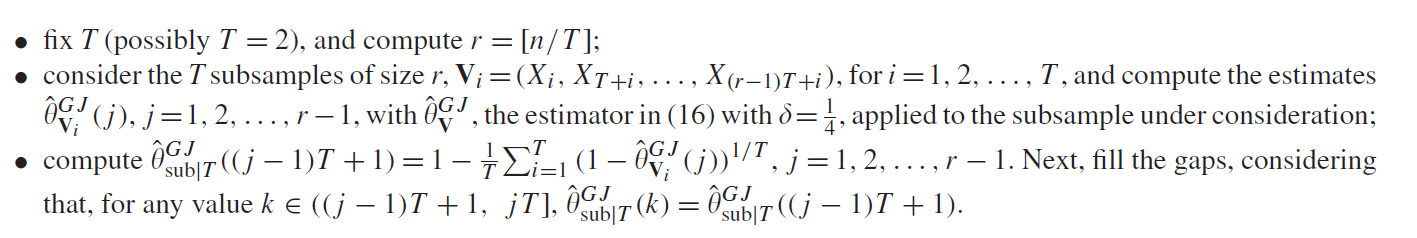

In [7]:
@njit
def subsampling_GJ(X, n, theta, T = 2, delta = 0.25):
    """
        The function for one run of the above algorithm
        
        Inputs:
            X: the armax array
            n: size of X
            theta: the actual value of theta (not used but kept for consistency in functions)
            T: number of subsamples (default: 2)
            delta: the delta for theta_GJ (default: 0.25)
            
        Returns:
            theta_sub: the values of theta with subsampling
    """
  # calculate r as the integral part of n/T  
  r = int(np.floor(n/T))

  # allocate space to store theta_Vi
  theta_Vi = np.zeros((T, r))

  # the loop in the second step
  for i in range(T):
    # subsampling taking every T-th element from the i-th position
    V = X[i:(r-1)*T+i+1:T]

    for j in range(1, r):
      # step 2: calculating the generalized jackknife estimate of the subsample
      theta_Vi[i][j] = theta_GJ_k(V, V.shape[0], j, delta)

  # allocating space for the theta_sub
  theta_sub = -1 * np.ones(n)  

  # calculating the mean of the estimate of theta of the subsamples
  for j in range(1, r):
    theta_sub[(j - 1)*T + 1] = 1 - ((np.power(1 - theta_Vi[:,j], 1/T)).mean())
    theta_sub[np.isnan(theta_sub)] = 0
  
  # filling the gaps as in step 3
  for k in range(1, n):
    if theta_sub[k] == -1:
      theta_sub[k] = theta_sub[k-1]

  # return the theta_sub as calculating
  return theta_sub

In [8]:
@njit
def simulate_mean_mse_GJ_sub(n, T = 2, theta = 0.2, delta = 0.25, replicates = 10, runs = 15):
    """
        Get the mean and mse of the subsampled generalised jackknife estimate of theta by running simulations
        
        Inputs:
            n: Size of the array to be generated
            T: number of subsamples
            theta: the extremal index, also the true value (default: 0.2)
            delta: the delta for the generalised jackknife estimate (default: 0.25)
            replicates: the number of replicates to be used (default: 10)
            runs: the number of simulations runs (default: 15, small number in order to not hang the system)
            
        Returns:
            mean, mse of the simulation
    """
  # the arrays to store the calculates values
  all_values_mean = np.zeros(n)
  all_values_mse = np.zeros(n)

  # loop for multiple runs
  for run in range(runs):
    # generating the armax of frechet distributiom
    a = np.zeros((replicates, n))
    for i in range(replicates):
      a[i] = armax(1-theta, 1, n)
    
    # allocating space for calculations
    path = np.zeros((replicates, n))
    path2 = np.zeros((replicates, n))

    # the number of k to be calculated
    k_range = list(range(n))

    # calculating the mean and mse for the current run
    for j in range(replicates):
      path[j] = subsampling_GJ(a[j], n, theta, T, delta)
      path2[j] = np.power((path[j] - theta), 2)

    # adding the mean values to the total
    all_values_mean += np_apply_along_axis(np.mean, 0, path)
    all_values_mse += np_apply_along_axis(np.mean, 0, path2)
    
  # returning the average values of the mean and mse
  return all_values_mean/runs, all_values_mse/runs

In [12]:
%%time

# declaring variables to be used
runs = 1000
replicates = 10
n = 5000
theta = 0.2
delta = 0.25

# calculating all kinds of estimates
e_1000_5, mse_1000_5 = simulate_mean_mse(n, theta, runs = runs, replicates = replicates)
e_1000_5_1, mse_1000_5_1 = simulate_mean_mse_GJ(n, theta, delta, runs = runs, replicates = replicates)
e_1000_5_2, mse_1000_5_2 = simulate_mean_mse_GJ_sub(n, 2, theta, delta, replicates, runs)
e_1000_5_3, mse_1000_5_3 = simulate_mean_mse_GJ_sub(n, 3, theta, delta, replicates, runs)
e_1000_5_4, mse_1000_5_4 = simulate_mean_mse_GJ_sub(n, 4, theta, delta, replicates, runs)

Wall time: 4h 36min 47s


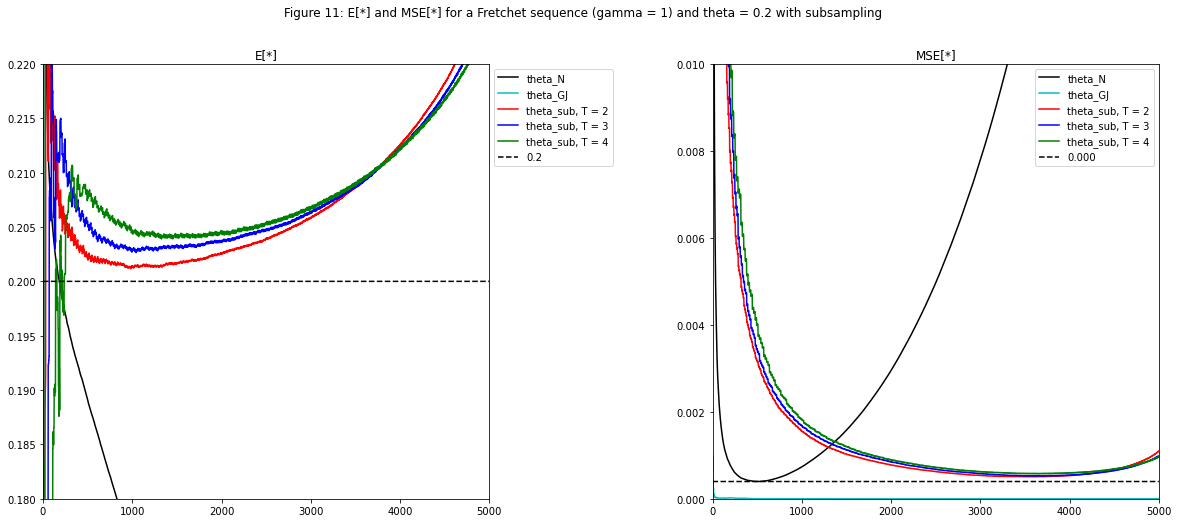

In [13]:
# plotting the graphs
straight_line = theta*np.ones(n)
k_range = np.arange(n)
fig, axs = plt.subplots(1, 2, figsize = (20,8))

fig.suptitle("Figure 11: E[*] and MSE[*] for a Fretchet sequence (gamma = 1) and theta = " + str(theta) + " with subsampling")
axs[0].set_ylim([0.18, 0.22])
axs[0].set_xlim([0,n])
axs[0].set_title("E[*]")
axs[0].plot(k_range, e_1000_5, 'k-', label = 'theta_N')
axs[0].plot(k_range, e_1000_5_1, 'c-', label = 'theta_GJ')
axs[0].plot(k_range, e_1000_5_2, 'r-', label = 'theta_sub, T = 2')
axs[0].plot(k_range, e_1000_5_3, 'b-', label = 'theta_sub, T = 3')
axs[0].plot(k_range, e_1000_5_4, 'g-', label = 'theta_sub, T = 4')
axs[0].plot(k_range, straight_line, 'k--', label = str(theta))
axs[0].legend(bbox_to_anchor=(1, 1))

m = mse_1000_5
mse_line = m[np.where(m == m.min())[0][0]] *np.ones(n)

axs[1].set_ylim([0, 0.01])
axs[1].set_xlim([0,n])
axs[1].set_title("MSE[*]")
axs[1].plot(k_range, mse_1000_5, 'k-', label = 'theta_N')
axs[1].plot(k_range, mse_1000_5_1, 'c-', label = 'theta_GJ')
axs[1].plot(k_range, mse_1000_5_2, 'r-', label = 'theta_sub, T = 2')
axs[1].plot(k_range, mse_1000_5_3, 'b-', label = 'theta_sub, T = 3')
axs[1].plot(k_range, mse_1000_5_4, 'g-', label = 'theta_sub, T = 4')
axs[1].plot(k_range, mse_line, 'k--', label = str(m[np.where(m == m.min())[0][0]])[:5])
axs[1].legend(bbox_to_anchor=(1, 1))

fig.subplots_adjust(wspace=0.5)